In [1]:
#!/usr/bin/python3
# import tensorflow as tf
import numpy as np
from math import exp
from numpy.random import binomial,shuffle,seed, choice
import pandas as pd
from IPython.display import display, clear_output
import os
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import CompactLSM

seed(4) # for replicating results

Reservoir Dimension set

In [2]:
nx = 5
ny = 5
nz = 5
N = nx*ny*nz                                          # Reservoir size

N_read = 10                                           # No. of Readout neurons

Important constants related to LIF neuron and synaptic model

In [3]:
global vrest, vth, t_refrac
vrest, vth, t_refrac = 0, 20, 2

tau_m = 32
params_potential = {'C':1, 'g_L':1/tau_m, 'E_L':vrest, 'V_T':vth, 'R_p':t_refrac}

Delay = 1 #constant delay for all synapses in ms

tau_c = 64
C_theta = 5
del_C = 3
n_bits = 8
delta_c = 1
params_conc = {'C_theta':C_theta, 'del_C':del_C, 'tau_c':64, 'nbits':n_bits, 'delta_c':delta_c}

syn_string = "first-order"

sampling_freq = 12.5 # in khz
h = 1 # in ms
α_w = 0.8
time_params = {'h':h, 'Delay':Delay}

Set Reservoir Connections

In [4]:
# Storing the IDs of the neurons
LSM_ID = np.zeros((nx,ny,nz),dtype=np.int64)
l = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            LSM_ID[i,j,k] = l
            l = l + 1

# Storing the synapse connections, and creating the initial weight matrix

k_prob = [0.45, 0.3, 0.6, 0.15]
r_sq = 2**2

W_arr = [3, 6, -2, -2]
W_init = 3
Weights_temp = np.zeros((N,N))

N_in = int(N*0.8)
neuron_type = [ int(i<N_in) for i in range(N)]
seed(4)
shuffle(neuron_type) # 1 for excitatory, 0 for inhibitory

synapes = [dict() for i in range(N)]    # an array of dictonaries which store the location of neuron, 
                                        # type of neuron, and the IDs of the neurons it is connected to

for l in range(N):
    loc = CompactLSM.ID_to_ind(nx,ny,nz,l)
    n_type = neuron_type[l]
    cons = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if l != int(LSM_ID[i,j,k]):
                    dist_sq = (loc[0]-i)**2 + (loc[1]-j)**2 + (loc[2]-k)**2
                    k_probl = 0
                    if n_type == 1:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[0]
                        W_init = W_arr[0]
                      else:
                        k_probl = k_prob[1]
                        W_init = W_arr[1]
                    else:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[2]
                        W_init = W_arr[2]
                      else:
                        k_probl = k_prob[3]
                        W_init = W_arr[3]

                    probability = k_probl* exp(-1*dist_sq/r_sq)
#                     print(probability)
                    check = binomial(1,probability)
                    if check == 1:
                        cons.append(int(LSM_ID[i,j,k]))
                        Weights_temp[l,int(LSM_ID[i,j,k])] = W_init    
    synapes[l] = {"Location":loc, "Neuron_type":n_type, "connections":cons}

global Weights
Weights = Weights_temp * α_w
print("Total synapse:", len(np.argwhere(Weights!=0)), 
        ",E --> E :", len(np.argwhere(Weights==W_arr[0] * α_w)), 
        ",E --> I:",len(np.argwhere(Weights==W_arr[1] * α_w)),
        ",I --> E/I:",len(np.argwhere(Weights==W_arr[2] * α_w)))
i = 64
print("Total Connections: for neuron {}:{}, {}".format(i,synapes[i]["Neuron_type"],synapes[i]["connections"]) )
Weights[1,2]

Total synapse: 1130 ,E --> E : 769 ,E --> I: 105 ,I --> E/I: 256
Total Connections: for neuron 64:1, [19, 62, 83, 84, 89, 93, 97, 109, 114, 118]


2.4000000000000004

Set Readout neuron initial Weights

In [5]:
All_labels = [str(x) for x in range(10)]
# N_read = 10                                           # No. of Readout neurons

Weights_temp_readOut = -8 + 16 * np.random.rand(N_read, N) # random weight initialization


synapes_read = []        # an array of dictonaries which store the label of neuron, 
                                                      # and the IDs of the neurons it is connected to

for l in range(N_read):
    label = All_labels[l]
    synapes_read.append(label)

Weights_readOut = Weights_temp_readOut

In [6]:
# creating file location and label arrays for train and validate

base = 'PreProcessing/trainBSA'
os.listdir(base)

train_Labels = []
file_name_List = []

for human in os.listdir(base):
    base_up = base + '/' + human
    for train_sample in os.listdir(base_up):
        train_Label = train_sample[0:2]
        file_loc = base_up + '/' + train_sample
        file_name_List.append(file_loc)
        train_Labels.append(train_Label)

seedval = 4

seed(seedval)
shuffle(train_Labels)
seed(seedval)
shuffle(file_name_List)

total_size = len(train_Labels)
train_size = int(total_size*0.8)

validate_Labels = train_Labels[train_size:total_size]
validate_file_list = file_name_List[train_size:total_size]

train_Labels = train_Labels[0:train_size]
train_file_list = file_name_List[0:train_size]

In [7]:
L = 78
Fin = 4
reservoir_ID = [i for i in range(N)]
seed(seedval)
Input_CXNs = choice(reservoir_ID, size = (L,Fin))
sign_win_matrix = (binomial(1,1/2, size = (L, Fin)) - 0.5)*2
# Input_CXNs * sign_win_matrix

### Finding input neurons to reservoir current and then using the spike train to find the current input to the reservoir

In [8]:
# print("Input neurons =",L)
print("Size of Reservoir =",nx,"X",ny,"X",nz,",Total total neurons =",N)
print("Total no.of read out neurons =",N_read)

Size of Reservoir = 5 X 5 X 5 ,Total total neurons = 125
Total no.of read out neurons = 10


In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (6.4 * 3, 4.8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)

#### Code for Reservoir Visulaization

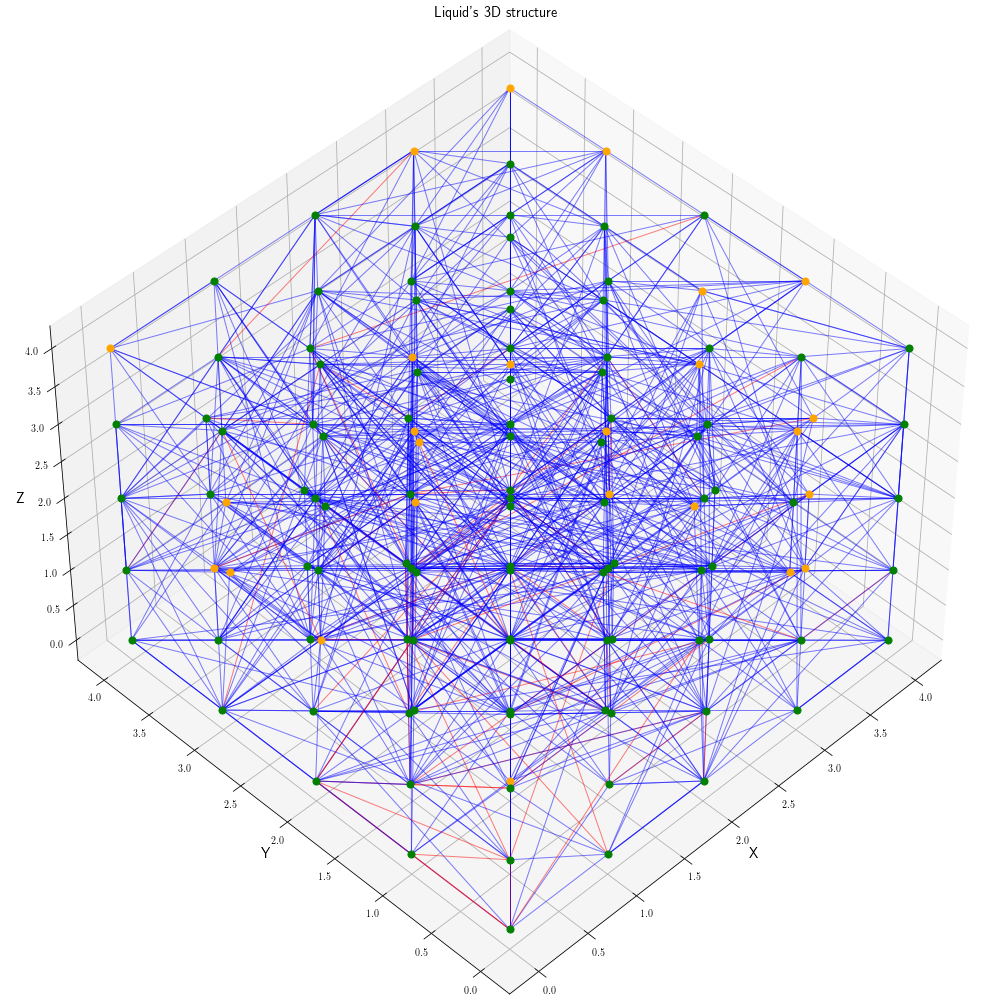

In [10]:
from matplotlib import pyplot as plt
fig_w = 32
fig_h = 18

elev_ang = 45
azim_ang = -135

marker_size = 50

p = 1

fig = plt.figure() # creates the figure for the following plots
fig.set_size_inches(fig_w,fig_h, forward=False) #Set the figure size
ax = fig.add_subplot(111, projection='3d') # setup to only one


for ID in range(N):
    location = synapes[ID]['Location']
    x = location[0]
    y = location[1]
    z = location[2]
    Neuron_tp = synapes[ID]['Neuron_type']
    if Neuron_tp == 1:
        ax.scatter(x,y,z, c = 'green', s = marker_size)
    else:
        ax.scatter(x,y,z, c = 'orange', s = marker_size)

    conns = synapes[ID]['connections']
    syns = len(conns)
    prob = binomial(1,p)
    if prob == 1:
        for i in range(syns):
            x1,y1,z1 = CompactLSM.ID_to_ind(nx,ny,nz,conns[i])
            
            if Weights[ID,i] > 0:
                colour = '#FF0000'
            else:
                colour = '#0000FF'
            ax.plot([x, x1], [ y, y1], [ z, z1], color=colour, linewidth=1, alpha = 0.5)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title("Liquid's 3D structure")

ax.view_init(elev=elev_ang, azim=azim_ang)

plt.show()

In [11]:
# # if need to exit training load last trained weights, else comment 
# made del_w 0.1 from 0.01 at 57th epoch
# load_idx = 12
# Weights_readOut_fromCsv = pd.read_csv("Weights_1stOrder/weights_epoch{}.csv".format(load_idx), sep=",", header=None)
# Weights_readOut = Weights_readOut_fromCsv.to_numpy()
# Weights_readOut_fromCsv = Weights_readOut_fromCsv.iloc[1:, 1:]
# Weights_readOut = Weights_readOut_fromCsv.to_numpy()
# Validation_accuracies = pd.read_csv("Val_accuracies.csv", sep=",", header=None)
# Validation_accuracies = Validation_accuracies.iloc[1:, 1].to_numpy()
# len(Validation_accuracies)

### Network Learning

Epoch: 1, Training input: 480(558), Truth:1(25), Predicted:1(25), Spikes:{1: 25, 0: 3, 2: 1, 7: 1, 3: 0, 4: 0, 5: 0, 6: 0, 8: 0, 9: 0}}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(0), Predicted:9(5), Spikes:{9: 5, 4: 3, 5: 3, 8: 2, 0: 0, 1: 0, 2: 0, 3: 0, 6: 0, 7: 0} 0}
Last Epoch validation rate:14.17


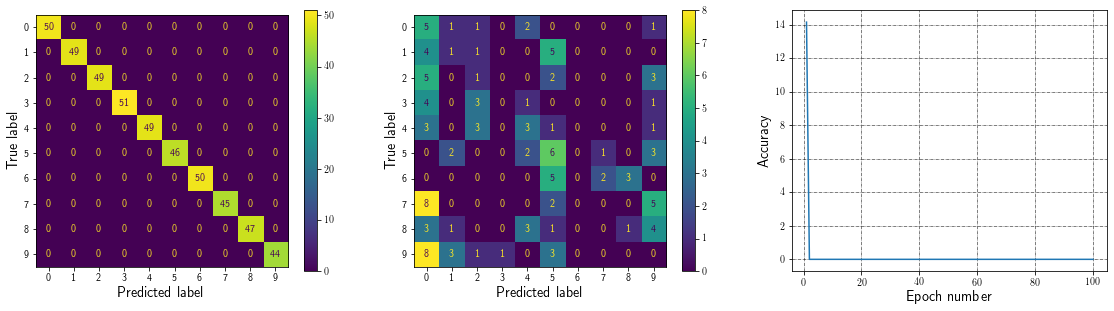

Epoch: 2, Training input: 480(558), Truth:1(25), Predicted:1(25), Spikes:{1: 25, 0: 1, 2: 1, 7: 1, 9: 1, 3: 0, 4: 0, 5: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(0), Predicted:5(3), Spikes:{5: 3, 9: 3, 4: 2, 8: 2, 0: 0, 1: 0, 2: 0, 3: 0, 6: 0, 7: 0} 0}
Last Epoch validation rate:24.17


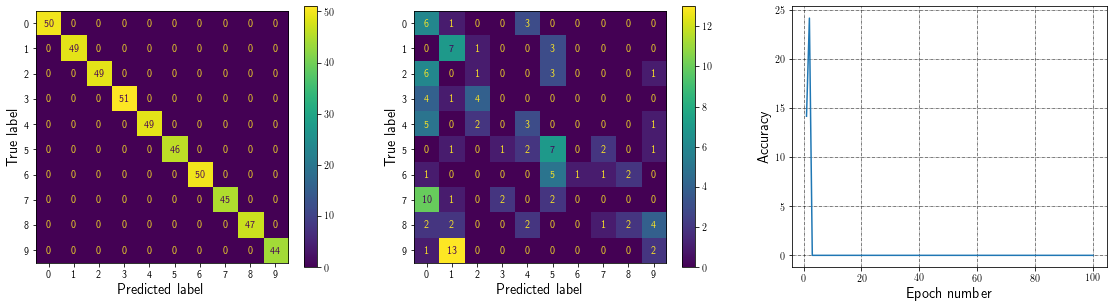

Epoch: 3, Training input: 480(558), Truth:1(25), Predicted:1(25), Spikes:{1: 25, 9: 3, 0: 1, 7: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(1), Predicted:8(3), Spikes:{8: 3, 4: 2, 5: 2, 9: 2, 0: 1, 2: 1, 1: 0, 3: 0, 6: 0, 7: 0} 0}
Last Epoch validation rate:25.83


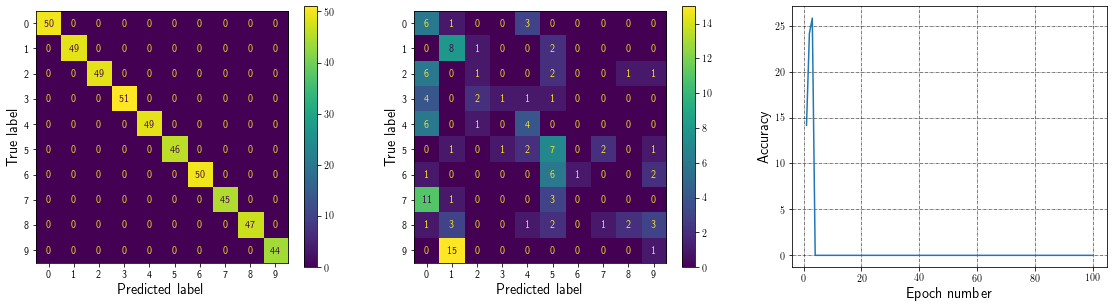

Epoch: 4, Training input: 480(558), Truth:1(25), Predicted:1(25), Spikes:{1: 25, 9: 4, 5: 1, 7: 1, 0: 0, 2: 0, 3: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(1), Predicted:8(3), Spikes:{8: 3, 0: 2, 4: 2, 9: 2, 2: 1, 5: 1, 1: 0, 3: 0, 6: 0, 7: 0} 0}
Last Epoch validation rate:30.83


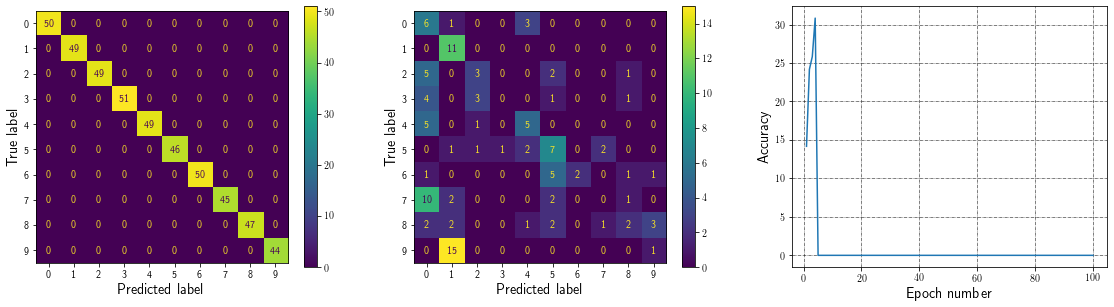

Epoch: 5, Training input: 480(558), Truth:1(25), Predicted:1(25), Spikes:{1: 25, 9: 6, 5: 2, 0: 0, 2: 0, 3: 0, 4: 0, 6: 0, 7: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(2), Predicted:8(3), Spikes:{8: 3, 0: 2, 2: 2, 4: 2, 5: 1, 7: 1, 9: 1, 1: 0, 3: 0, 6: 0} 0}
Last Epoch validation rate:31.67


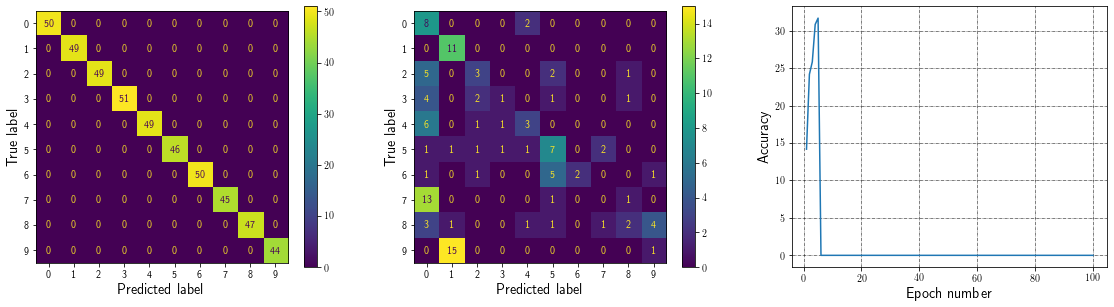

Epoch: 6, Training input: 480(558), Truth:1(26), Predicted:1(26), Spikes:{1: 26, 9: 6, 5: 2, 0: 0, 2: 0, 3: 0, 4: 0, 6: 0, 7: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(2), Predicted:8(3), Spikes:{8: 3, 0: 2, 2: 2, 4: 2, 5: 1, 7: 1, 9: 1, 1: 0, 3: 0, 6: 0} 0}
Last Epoch validation rate:31.67


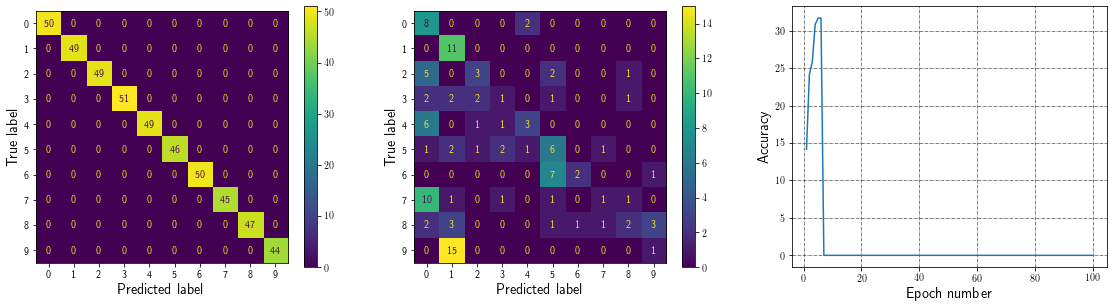

Epoch: 7, Training input: 480(558), Truth:1(26), Predicted:1(26), Spikes:{1: 26, 9: 6, 5: 3, 0: 0, 2: 0, 3: 0, 4: 0, 6: 0, 7: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(3), Predicted:8(4), Spikes:{8: 4, 0: 3, 2: 3, 4: 2, 3: 1, 7: 1, 9: 1, 1: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:34.17


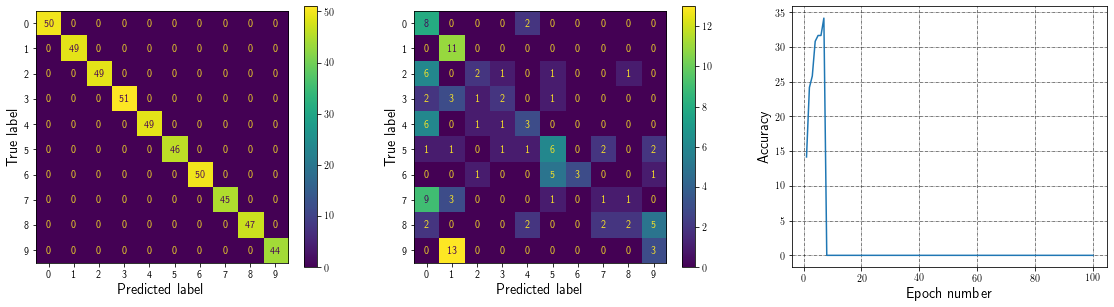

Epoch: 8, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 3, 0: 0, 2: 0, 3: 0, 4: 0, 6: 0, 7: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(4), Predicted:2(4), Spikes:{2: 4, 8: 4, 0: 2, 4: 2, 7: 1, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:39.17


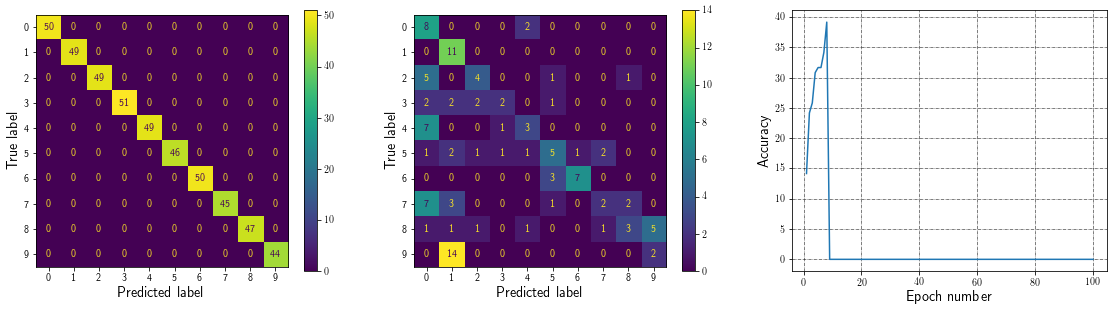

Epoch: 9, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 4, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(4), Predicted:2(4), Spikes:{2: 4, 8: 4, 0: 3, 4: 1, 7: 1, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:41.67


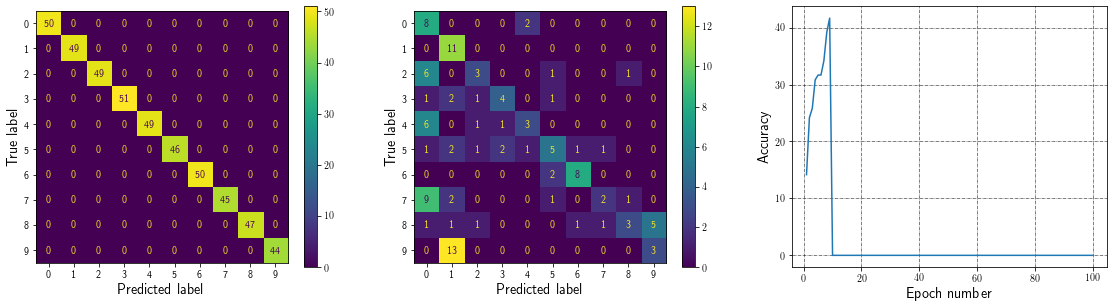

Epoch: 10, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 4, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(4), Predicted:2(4), Spikes:{2: 4, 8: 4, 0: 3, 4: 3, 7: 1, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:43.33


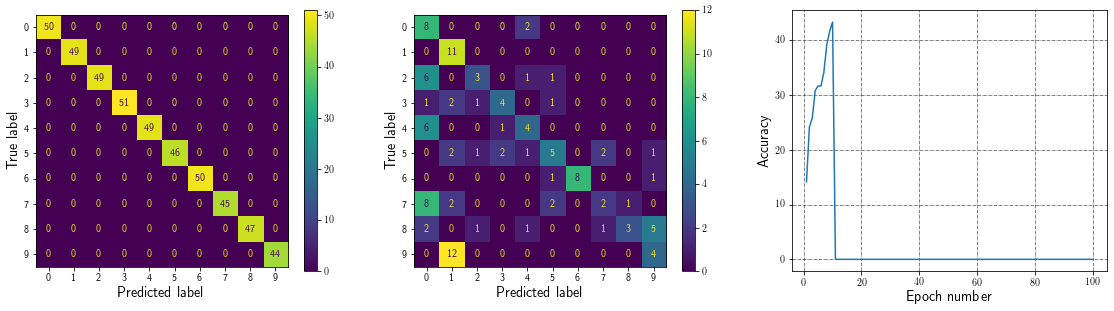

Epoch: 11, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 5, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(4), Predicted:2(4), Spikes:{2: 4, 8: 4, 0: 2, 4: 2, 7: 1, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0}0}}
Last Epoch validation rate:41.67


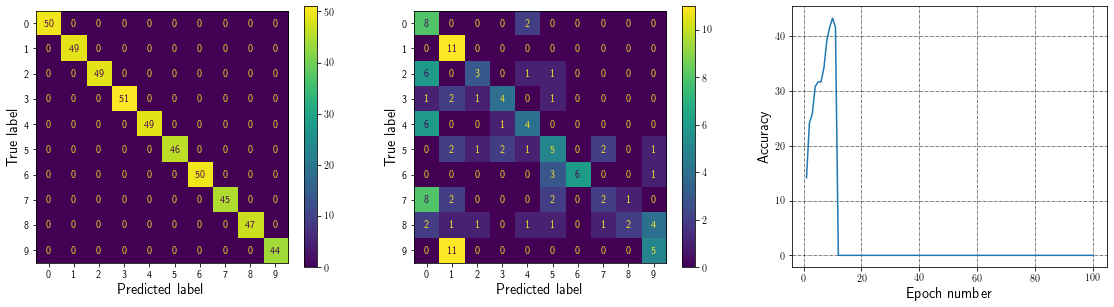

Epoch: 12, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 4, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(4), Predicted:2(4), Spikes:{2: 4, 8: 4, 0: 3, 4: 2, 7: 1, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0}0}}
Last Epoch validation rate:40.83


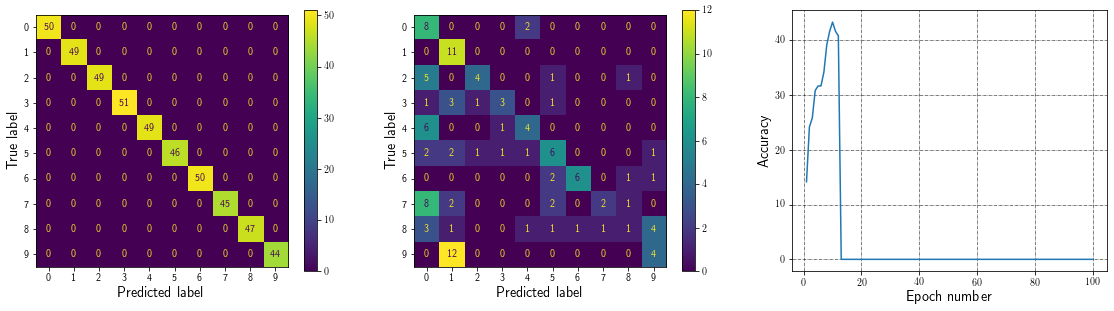

Epoch: 13, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 5, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(4), Predicted:2(4), Spikes:{2: 4, 8: 4, 0: 3, 4: 2, 7: 2, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:42.5


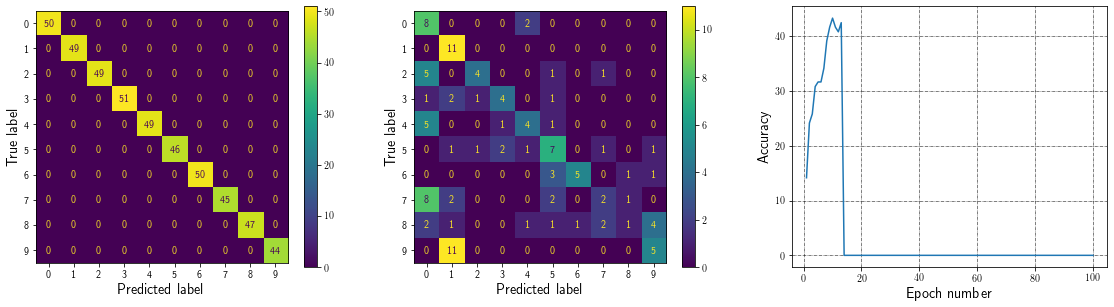

Epoch: 14, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 5, 7: 2, 3: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(5), Predicted:2(5), Spikes:{2: 5, 8: 4, 0: 3, 4: 2, 7: 2, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0}0}}
Last Epoch validation rate:45.0


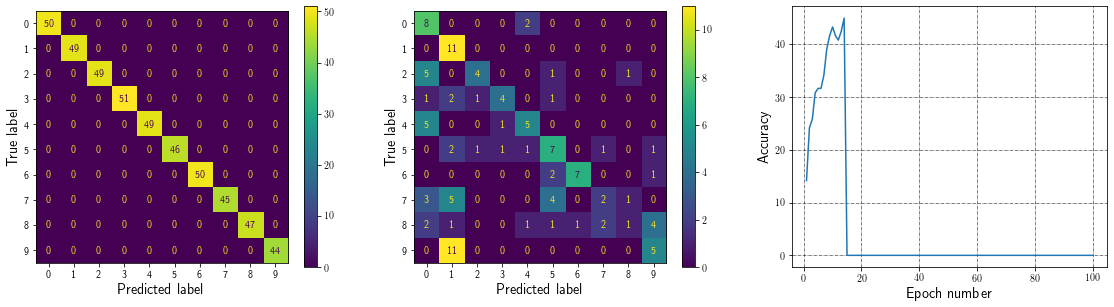

Epoch: 15, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 5, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(5), Predicted:2(5), Spikes:{2: 5, 0: 4, 8: 4, 4: 2, 9: 2, 7: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:46.67


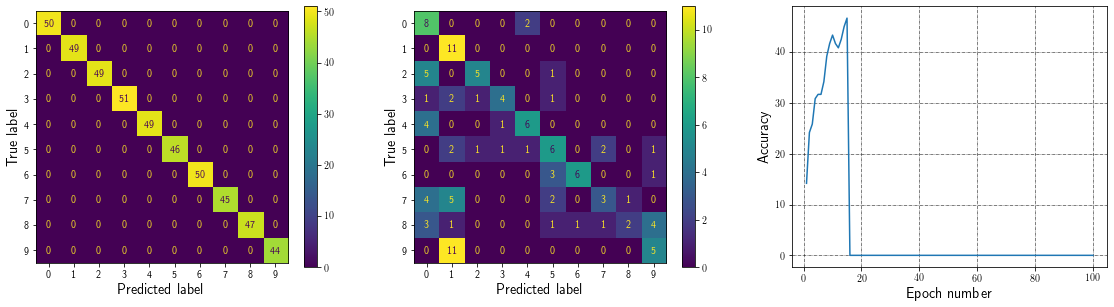

Epoch: 16, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 4, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(5), Predicted:2(5), Spikes:{2: 5, 8: 4, 0: 2, 9: 2, 4: 1, 7: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:47.5


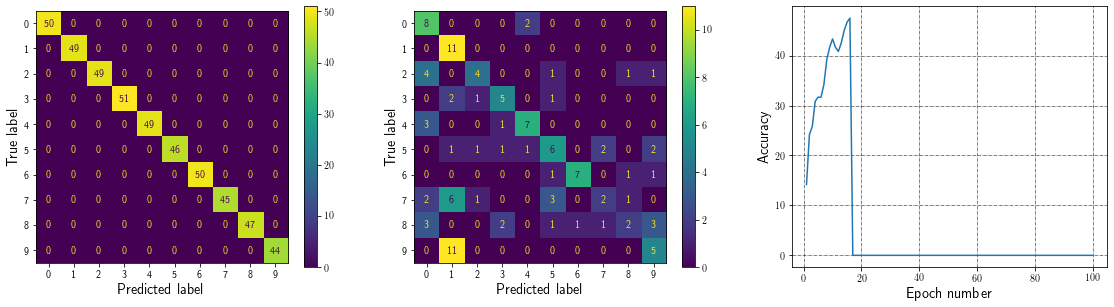

Epoch: 17, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 5, 3: 2, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(6), Predicted:2(6), Spikes:{2: 6, 0: 4, 8: 4, 4: 2, 9: 2, 7: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:45.83


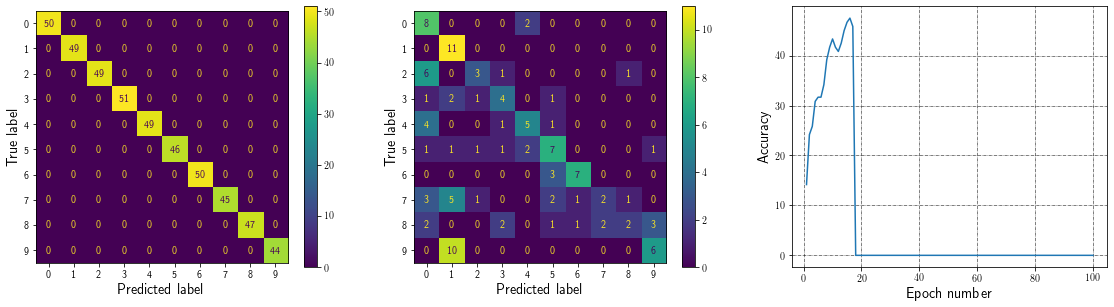

Epoch: 18, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 7, 5: 4, 3: 2, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(6), Predicted:2(6), Spikes:{2: 6, 8: 4, 0: 3, 9: 2, 4: 1, 7: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:50.83


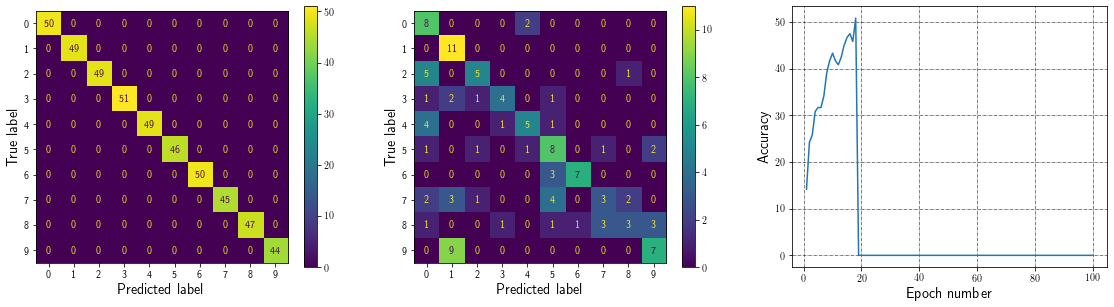

Epoch: 19, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 5, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(6), Predicted:2(6), Spikes:{2: 6, 8: 5, 0: 3, 4: 2, 7: 2, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:53.33


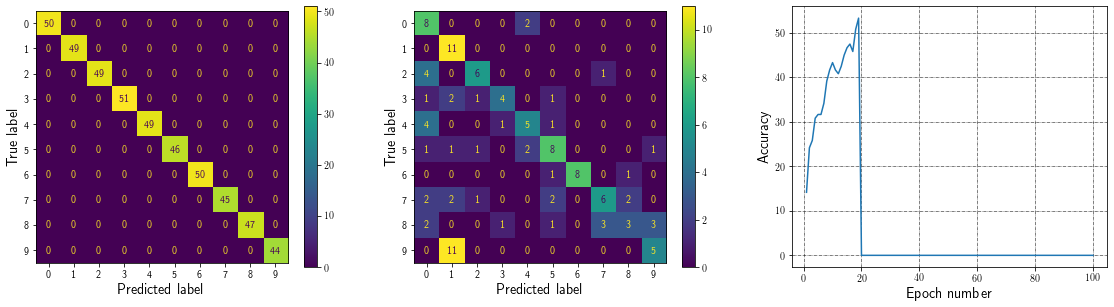

Epoch: 20, Training input: 480(558), Truth:1(27), Predicted:1(27), Spikes:{1: 27, 9: 6, 5: 4, 3: 1, 7: 1, 0: 0, 2: 0, 4: 0, 6: 0, 8: 0}}
Last Epoch Training rate:100.0
**************************************************
Validate Input: 120(553), Truth:2(6), Predicted:2(6), Spikes:{2: 6, 8: 4, 0: 3, 4: 2, 7: 1, 9: 1, 1: 0, 3: 0, 5: 0, 6: 0} 0}
Last Epoch validation rate:51.67


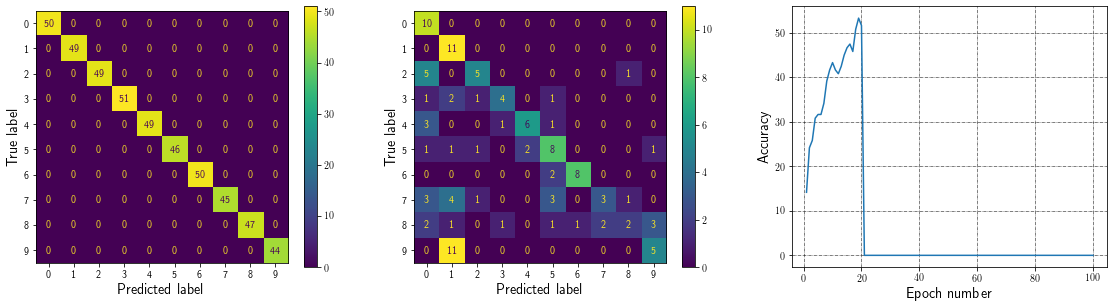

Epoch: 21, Training input: 434(616), Truth:8(27), Predicted:8(27), Spikes:{8: 27, 6: 3, 7: 3, 9: 3, 3: 2, 4: 2, 0: 0, 1: 0, 2: 0, 5: 0}}

In [ ]:
# Training
EPOCHS = 100  # From paper
All_reservoir_spikes = []
Weights_epoch_save = []
prediction_rate = np.zeros((EPOCHS, ))
Validation_rate = np.zeros((EPOCHS, ))
# Validation_rate = Validation_accuracies
Validation_accuracies = Validation_rate
epochs_here = [epoch for epoch in range(1, EPOCHS+ 1)]
for epoch in range(EPOCHS):
    print("=" * 50)
    fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

    correct_predictions = 0
    True_labels, classified_labels = [], []
    Input_gen_func = CompactLSM.Input_current_gen(train_file_list,
                                                  syn_string,
                                                  N,
                                                  time_params,
                                                  Input_CXNs,
                                                  sign_win_matrix,
                                                  training=True,
                                                  train_Labels=train_Labels)
    NUM_INPUTS = len(train_Labels)

    for i in range(NUM_INPUTS):
        In_app, L, M, train_Label, input_num = next(
            Input_gen_func)  # Generates next input

        [Reservoir_potential, Reservoir_Spikes
         ] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app,
                                         params_potential, Weights, syn_string)

        All_reservoir_spikes.append(Reservoir_Spikes)
        Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(
            N_read,
            N,
            Delay,
            synapes,
            M,
            h,
            Reservoir_Spikes,
            params_potential,
            params_conc,
            Weights_readOut,
            syn_string,
            training=True,
            train_ids=[train_Label])

        class_out_label, class_out_idx, No_of_spikes = CompactLSM.classifier(
            Readout_Spikes, synapes_read)
        Weights_readOut = trained_weights

        No_of_spikes = {i: int(No_of_spikes[i]) for i in range(10)}
        No_of_spikes = {
            k: v
            for k, v in sorted(
                No_of_spikes.items(), key=lambda item: item[1], reverse=True)
        }
        display_string = "Epoch: {}, Training input: {}({}), Truth:{}({}), Predicted:{}({}), Spikes:{}".format(
            epoch + 1, i + 1,len(np.argwhere(Reservoir_Spikes==1)), train_Label, No_of_spikes[int(train_Label)],
            class_out_label, No_of_spikes[int(class_out_label)], No_of_spikes)
        print("\r" + display_string, end="")

        True_labels.append(int(train_Label))
        classified_labels.append(int(class_out_label))
        if int(class_out_label) == int(train_Label):
            correct_predictions += 1
#     break
    Weights_epoch_save.append(Weights_readOut)
    prediction_rate[epoch] = correct_predictions / NUM_INPUTS

    path = "Weights_1stOrder/"
    file = "weights_epoch{}.csv".format(epoch + 1)
    pd.DataFrame(Weights_readOut).to_csv(path + file)
    display_string = "Last Epoch Training rate:{}".format(
        prediction_rate[epoch] * 100)
    print("\n" + display_string)
    pd.DataFrame(prediction_rate).to_csv("Train_accuracies.csv")
    cm_train = confusion_matrix(True_labels,
                                classified_labels,
                                labels=[i for i in range(10)])
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                        display_labels=[i for i in range(10)])
    disp_train.plot(ax=ax1)
    print("*" * 50)

    ############### Online learning Validation ###################
    Input_gen_func = CompactLSM.Input_current_gen(validate_file_list,
                                                  syn_string,
                                                  N,
                                                  time_params,
                                                  Input_CXNs,
                                                  sign_win_matrix,
                                                  training=True,
                                                  train_Labels=validate_Labels)
    NUM_INPUTS = len(validate_Labels)

    correct_predictions = 0
    True_labels, classified_labels = [], []
    for i in range(NUM_INPUTS):
        In_app, L, M, validate_Label, input_num = next(
            Input_gen_func)  # Generates next input

        [Reservoir_potential, Reservoir_Spikes
         ] = CompactLSM.reservoir_solver(N, Delay, synapes, M, h, In_app,
                                         params_potential, Weights, syn_string)

        Readout_potential, Readout_Spikes, trained_weights = CompactLSM.readOut_response(
            N_read,
            N,
            Delay,
            synapes,
            M,
            h,
            Reservoir_Spikes,
            params_potential,
            params_conc,
            Weights_readOut,
            syn_string,
            training=False,
            train_ids=[validate_Label])

        class_out_label, class_out_idx, No_of_spikes = CompactLSM.classifier(
            Readout_Spikes, synapes_read)
        #         Weights_readOut = trained_weights
        No_of_spikes = {i: int(No_of_spikes[i]) for i in range(10)}
        No_of_spikes = {
            k: v
            for k, v in sorted(
                No_of_spikes.items(), key=lambda item: item[1], reverse=True)
        }
        display_string = "Validate Input: {}({}), Truth:{}({}), Predicted:{}({}), Spikes:{}".format(
            i + 1,len(np.argwhere(Reservoir_Spikes==1)), validate_Label, No_of_spikes[int(validate_Label)],
            class_out_label, No_of_spikes[int(class_out_label)], No_of_spikes)
        print("\r" + display_string, end="")

        True_labels.append(int(validate_Label))
        classified_labels.append(int(class_out_label))
        if int(class_out_label) == int(validate_Label):
            correct_predictions += 1
    
    Validation_rate[epoch] = correct_predictions / NUM_INPUTS
    display_string = "Last Epoch validation rate:{}".format(
        np.round(Validation_rate[epoch] * 100, 2))
    print("\n" + display_string)
    pd.DataFrame(Validation_rate).to_csv("Val_accuracies.csv")
    
    cm_validate = confusion_matrix(True_labels,
                                   classified_labels,
                                   labels=[i for i in range(10)])
    disp_validate = ConfusionMatrixDisplay(
        confusion_matrix=cm_validate, display_labels=[i for i in range(10)])
    disp_validate.plot(ax=ax2)
    Validation_accuracies[epoch] = np.round(Validation_rate[epoch] * 100, 2)
    ax3.plot(epochs_here, Validation_accuracies)
    ax3.grid(which='both', color='k', linestyle='-.', linewidth=0.5)
    ax3.set_ylabel("Accuracy")
    ax3.set_xlabel("Epoch number")
    plt.savefig("States/" + "epoch{}.png".format(epoch + 1), dpi=300)
    plt.show()